In [1]:
import time
import numpy as np
from numba import typed
from pyloki.simulation.pulse import PulseSignalConfig
from pyloki.config import PulsarSearchConfig
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import Periodogram
from pyloki.detection import scoring
from pyloki.utils import np_utils
from matplotlib import pyplot as plt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


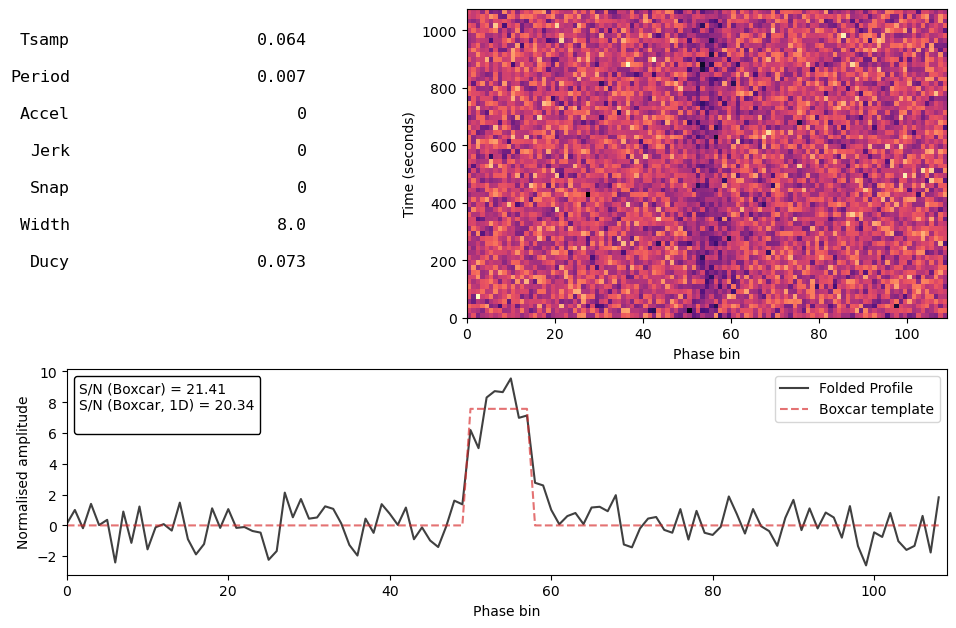

In [2]:
pulsar_period = 0.007# (s)
dt = 64e-6
nsamps = 2**24

cfg = PulseSignalConfig(period=pulsar_period, dt=dt, snr=20, ducy=0.1, nsamps=nsamps, over_sampling=1)
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins); plt.show()

In [3]:
tol_bins = cfg.tol_bins
fold_bins = cfg.fold_bins

tol_bins = 4
param_limits = typed.List([(1/0.0075, 1/0.0065)])
bseg_brute = cfg.nsamps//2048
search_cfg = PulsarSearchConfig(cfg.nsamps, cfg.dt, fold_bins, tol_bins, param_limits, bseg_brute=bseg_brute)
dyp = DynamicProgramming(tim_data, search_cfg)
dyp.initialize()
dyp.execute()

2024-09-10 23:49:27 INFO     - pyloki.ffa - Initializing data structure...

                    INFO     - pyloki.ffa - param steps: [0.07087311]

2024-09-10 23:49:32 INFO     - pyloki.ffa - fold dimensions: (2048, 289, 2, 109)

                    INFO     - pyloki.ffa - ffa_initialize finished, Elapsed time: 5.594 seconds

                    INFO     - pyloki.ffa - param steps: [0.03521552]

2024-09-10 23:49:34 INFO     - pyloki.ffa - i_iter: 1, fold dims: (1024, 582, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.01755302]

2024-09-10 23:49:35 INFO     - pyloki.ffa - i_iter: 2, fold dims: (512, 1168, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00876289]

                    INFO     - pyloki.ffa - i_iter: 3, fold dims: (256, 2340, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00437805]

                    INFO     - pyloki.ffa - i_iter: 4, fold dims: (128, 4685, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00218817]

                    INFO     - pyloki.ffa - i_iter: 5, fold dims: (64, 9374, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00109388]

                    INFO     - pyloki.ffa - i_iter: 6, fold dims: (32, 18752, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00054688]

                    INFO     - pyloki.ffa - i_iter: 7, fold dims: (16, 37508, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00027343]

2024-09-10 23:49:36 INFO     - pyloki.ffa - i_iter: 8, fold dims: (8, 75020, 2, 109)

                    INFO     - pyloki.ffa - param steps: [0.00013671]

                    INFO     - pyloki.ffa - i_iter: 9, fold dims: (4, 150044, 2, 109)

                    INFO     - pyloki.ffa - param steps: [6.8354778e-05]

                    INFO     - pyloki.ffa - i_iter: 10, fold dims: (2, 300093, 2, 109)

                    INFO     - pyloki.ffa - param steps: [3.41771821e-05]

2024-09-10 23:49:37 INFO     - pyloki.ffa - i_iter: 11, fold dims: (1, 600190, 2, 109)

                    INFO     - pyloki.ffa - ffa_execute finished, Elapsed time: 4.363 seconds

In [4]:
folds = dyp.get_fold_norm()
widths = scoring.generate_box_width_trials(dyp.nbins, ducy_max=0.2, spacing_factor=1)
snrs = scoring.boxcar_snr(folds, widths)
idx_freq = np_utils.find_nearest_sorted_idx(dyp.param_arr[-1], cfg.freq)
true_params_idx = (idx_freq)
print(f"True param indices: {true_params_idx}")

pgram = Periodogram(params={"width": widths, "freq": dyp.param_arr[-1]}, 
                    snrs=snrs, tobs=tim_data.tobs)
print(f"Best param indices: {pgram.find_best_indices()}")
print(pgram.get_summary())

True param indices: 278659
Best param indices: (np.int64(278660), np.int64(7))
Best S/N: 19.24
Best Period: 0.006999998504749813
Best freq: 142.85717337245933
Best width: 8


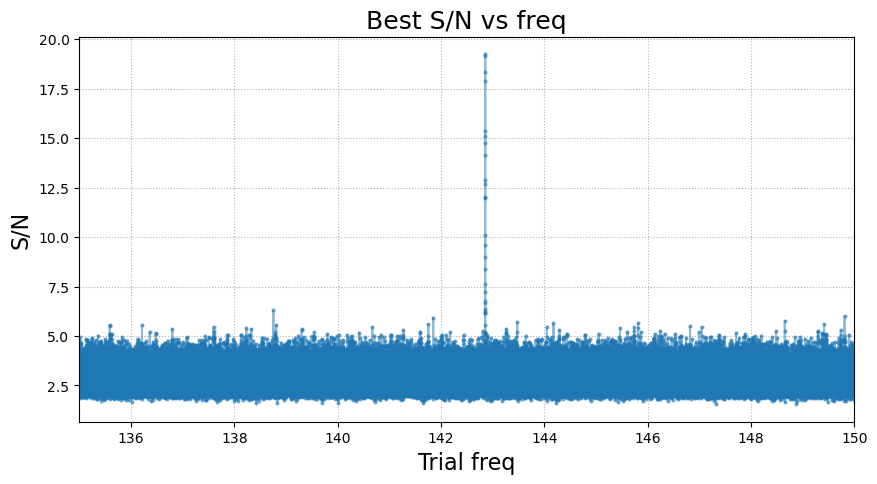

In [5]:
fig = pgram.plot_1d("freq", x_lim=(135, 150), figsize=(10, 5)); plt.show()